In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

sns.set_context("talk")
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr


from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)

from src.load_data import load_data
from src.parameters import ANIMALS
from ZilongCode.utils import (
    get_steps,
    get_diffusion_exponent,
)

In [3]:
epoch_key = ("bon", 8, 4)
data = load_data(epoch_key)

Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [7]:
datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories"
)

animal, day, epoch = epoch_key
# load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(
    os.path.join(
        datafolder,
        f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
    )
)

# get all time slice
t = data["position_info"].index / np.timedelta64(1, "s")

# load multiunit times
multiunit_times = [
    get_multiunit_dataframe(tetrode_key, ANIMALS)
    for tetrode_key in data["tetrode_info"].index
]
if multiunit_times[0] is None:
    multiunit_times = [
        get_multiunit_dataframe2(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]
# reset index in multiunit_times to seconds and replace the original multiunit_times
for i in range(len(multiunit_times)):
    indext_i = multiunit_times[i].index / np.timedelta64(1, "s")
    multiunit_times[i].index = indext_i

In [69]:
def plot_theta_examples(time_slice_sweep, t, multiunit_times, results, data, savename):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice: the time slice to plot
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
        a plot with 3 subplots
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    fig = plt.figure(figsize=(9, 3), dpi=300)

    cols = len(time_slice_sweep)
    gs = gridspec.GridSpec(4, cols, height_ratios=[0.5, 1, 3, 1])

    for i in range(cols):

        time_slice_sweep_i = time_slice_sweep[i]
        print(time_slice_sweep_i)

        ax1 = plt.subplot(gs[0, i])

        ind = 0
        lfp = (
            data["lfps"]
            .reset_index(drop=True)
            .set_index(data["lfps"].index / np.timedelta64(1, "s"))
        )

        # plot as curve, not fill
        ax1.plot(
            lfp.loc[time_slice_sweep_i].index.values,
            lfp.loc[time_slice_sweep_i].iloc[:, ind].values.squeeze(),
            color="grey",
            linewidth=1,
        )
        ax1.set_ylabel("LFP")

        # remove xticks
        ax1.set_xticks([])
        # remove y ticks
        ax1.set_yticks([])

        # ax2
        ax2 = plt.subplot(gs[1, i])

        n_tetrodes = len(multiunit_times)

        # eventplot with small dot
        ax2.eventplot(
            [multiunit.loc[time_slice_sweep_i].index for multiunit in multiunit_times],
            color="black",
            clip_on=False,
            linewidths=0.5,
        )

        ax2.set_yticks((1, n_tetrodes))
        # move the y ticks to right
        ax2.yaxis.tick_right()
        # remove y tick bars
        ax2.tick_params(axis="y", length=0)
        ax2.set_ylim((1, n_tetrodes))
        ax2.set_ylabel("Tet. id")
        ax2.set_xticks([])
        sns.despine(ax=ax2, offset=5)
        ax2.spines["bottom"].set_visible(False)

        # ax 3
        ax3 = plt.subplot(gs[2, i])
        # plot
        results["acausal_posterior"].sum("state", skipna=False).sel(
            time=time_slice_sweep_i
        ).plot(
            x="time",
            y="position",
            robust=True,
            ax=ax3,
            cmap=cmap,
            vmin=0.0,
        )

        ax3.plot(
            data["position_info"]
            .reset_index()
            .set_index(t)
            .loc[time_slice_sweep_i]
            .index,
            data["position_info"]
            .reset_index()
            .set_index(t)
            .loc[time_slice_sweep_i]
            .linear_position,
            color="darkturquoise",
            linestyle="-",
            linewidth=2,
            alpha=1,
        )

        # remove all labels, ticks and spines in axi, as well as colorbars
        ax3.set_xlabel("")
        ax3.set_ylabel("")
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.spines["right"].set_visible(False)
        ax3.spines["top"].set_visible(False)
        ax3.spines["left"].set_visible(False)
        ax3.spines["bottom"].set_visible(False)
        ax3.collections[0].colorbar.remove()

        # ax4
        ax4 = plt.subplot(gs[3, i])
        results.mental_distance_from_actual_position.sel(time=time_slice_sweep_i).plot(
            x="time", ax=ax4, color="#F18D00", linewidth=1, alpha=0.8
        )
        # set y label as 'Offset' and x label empty
        ax4.set_ylabel("", fontsize=labelsize)
        ax4.set_xlabel("", fontsize=labelsize)
        # set ticks off
        ax4.set_yticks([0, 40])
        ax4.set_xticks(
            [
                np.round(time_slice_sweep_i.start, 1),
                np.round(time_slice_sweep_i.stop, 1),
            ]
        )
        # tick labels without scientific notation
        ax4.ticklabel_format(useOffset=False, style="plain")
        # set tick font size as ticksize
        ax4.tick_params(labelsize=ticksize)

        # set x ticks with time_slice_sweep.start and time_slice_sweep.stop, keep one decimal
        ax4.set_xticks(
            [
                np.round(time_slice_sweep_i.start, 1),
                np.round(time_slice_sweep_i.stop, 1),
            ]
        )

        # add back ax4 bottom and left spines
        ax4.spines["bottom"].set_visible(True)
        ax4.spines["left"].set_visible(True)
        # set axis linewidth 1.0
        ax4.spines["bottom"].set_linewidth(1.0)
        ax4.spines["left"].set_linewidth(1.0)

        # xlim to the same
        ax1.set_xlim((time_slice_sweep_i.start - 0.1, time_slice_sweep_i.stop))
        ax2.set_xlim((time_slice_sweep_i.start - 0.1, time_slice_sweep_i.stop))
        ax3.set_xlim((time_slice_sweep_i.start - 0.1, time_slice_sweep_i.stop))
        ax4.set_xlim((time_slice_sweep_i.start - 0.1, time_slice_sweep_i.stop))

    # set ticks and spines
    all_axes = fig.get_axes()
    for ax in all_axes:
        ax.tick_params(labelsize=ticksize)
        ax.xaxis.label.set_size(labelsize)
        ax.yaxis.label.set_size(labelsize)
        # set axes off bottom left top and right
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # align y labels of ax1 and ax2

    plt.tight_layout()

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = (
        "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
    )

    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

slice(3891.0186, 3896.5186, None)


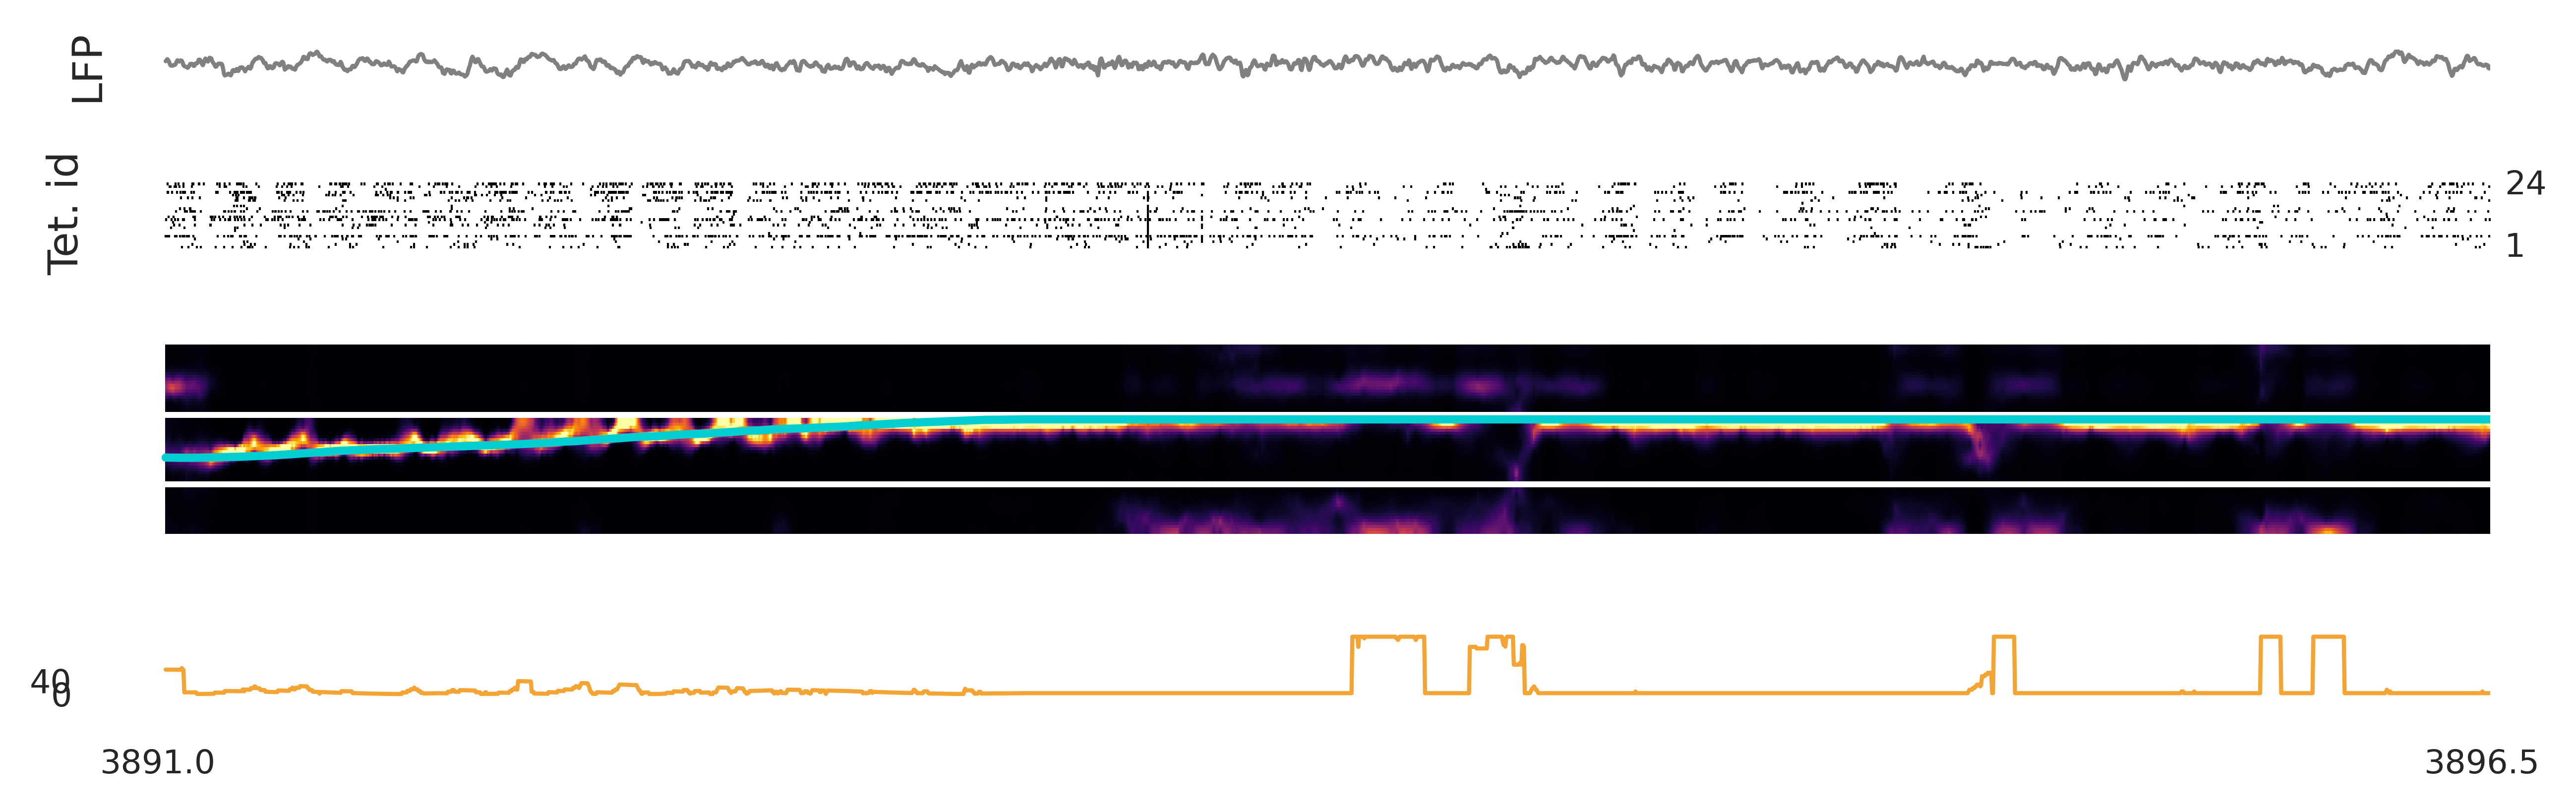

In [80]:
time_slice = slice(t.min(), t.max())  # 107-117
time_slice_sweep_1 = slice(t.min() + 245, t.min() + 250.5)

time_slice_sweep = [
    time_slice_sweep_1,
]

plot_theta_examples(
    time_slice_sweep,
    t,
    multiunit_times,
    cv_classifier_clusterless_results,
    data,
    savename="FigSI_theta_sweep_more_examples1.png",
)

slice(3652.0186, 3655.0186, None)
slice(3746.0186, 3748.0186, None)
slice(3891.0186, 3893.0186, None)
slice(3956.0186, 3958.0186, None)


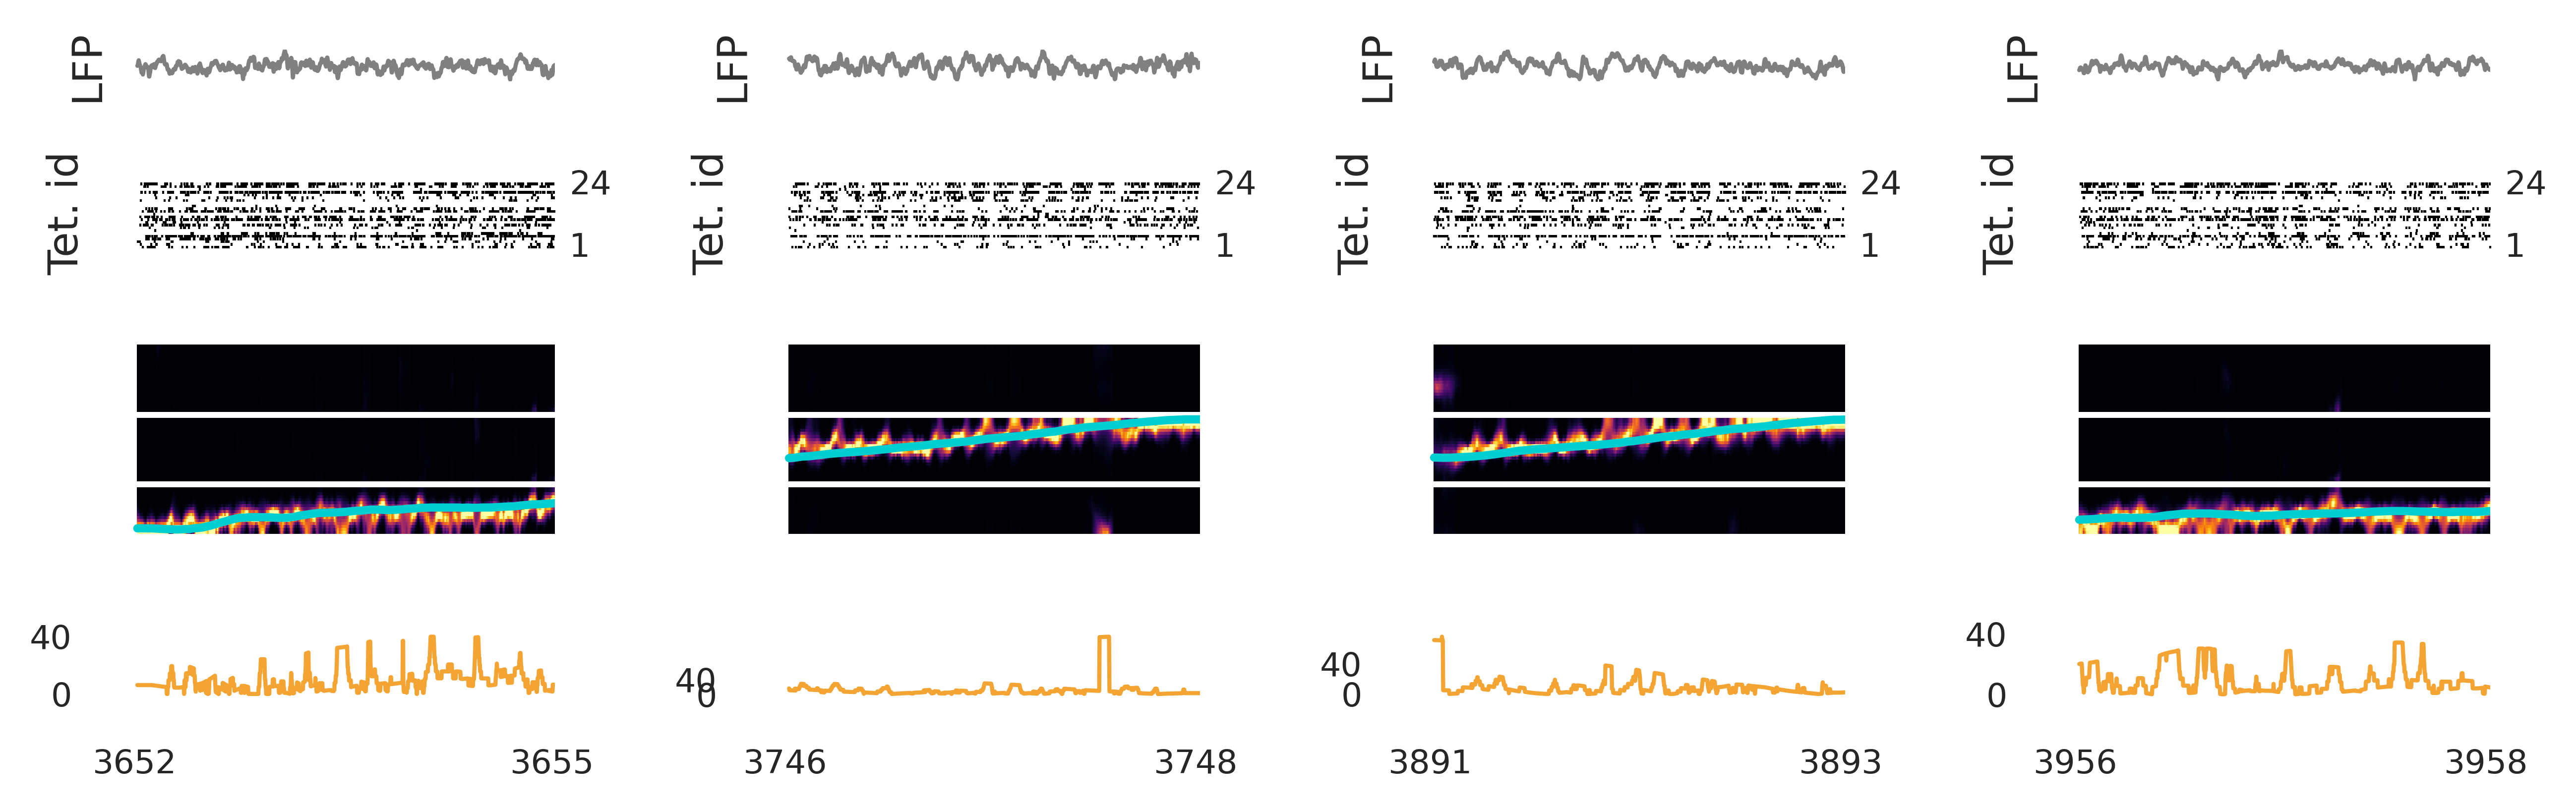

In [85]:
time_slice = slice(t.min(), t.max())  # 107-117
time_slice_sweep_1 = slice(t.min() + 6, t.min() + 9)
time_slice_sweep_2 = slice(t.min() + 100, t.min() + 102)
time_slice_sweep_3 = slice(t.min() + 245, t.min() + 247)
time_slice_sweep_4 = slice(t.min() + 310, t.min() + 312)

time_slice_sweep = [
    time_slice_sweep_1,
    time_slice_sweep_2,
    time_slice_sweep_3,
    time_slice_sweep_4,
]

plot_theta_examples(
    time_slice_sweep,
    t,
    multiunit_times,
    cv_classifier_clusterless_results,
    data,
    savename="FigSI_theta_sweep_more_examples1.png",
)

slice(4101.018599999999, 4103.018599999999, None)
slice(4167.018599999999, 4169.018599999999, None)
slice(4281.018599999999, 4283.018599999999, None)
slice(4336.018599999999, 4338.018599999999, None)


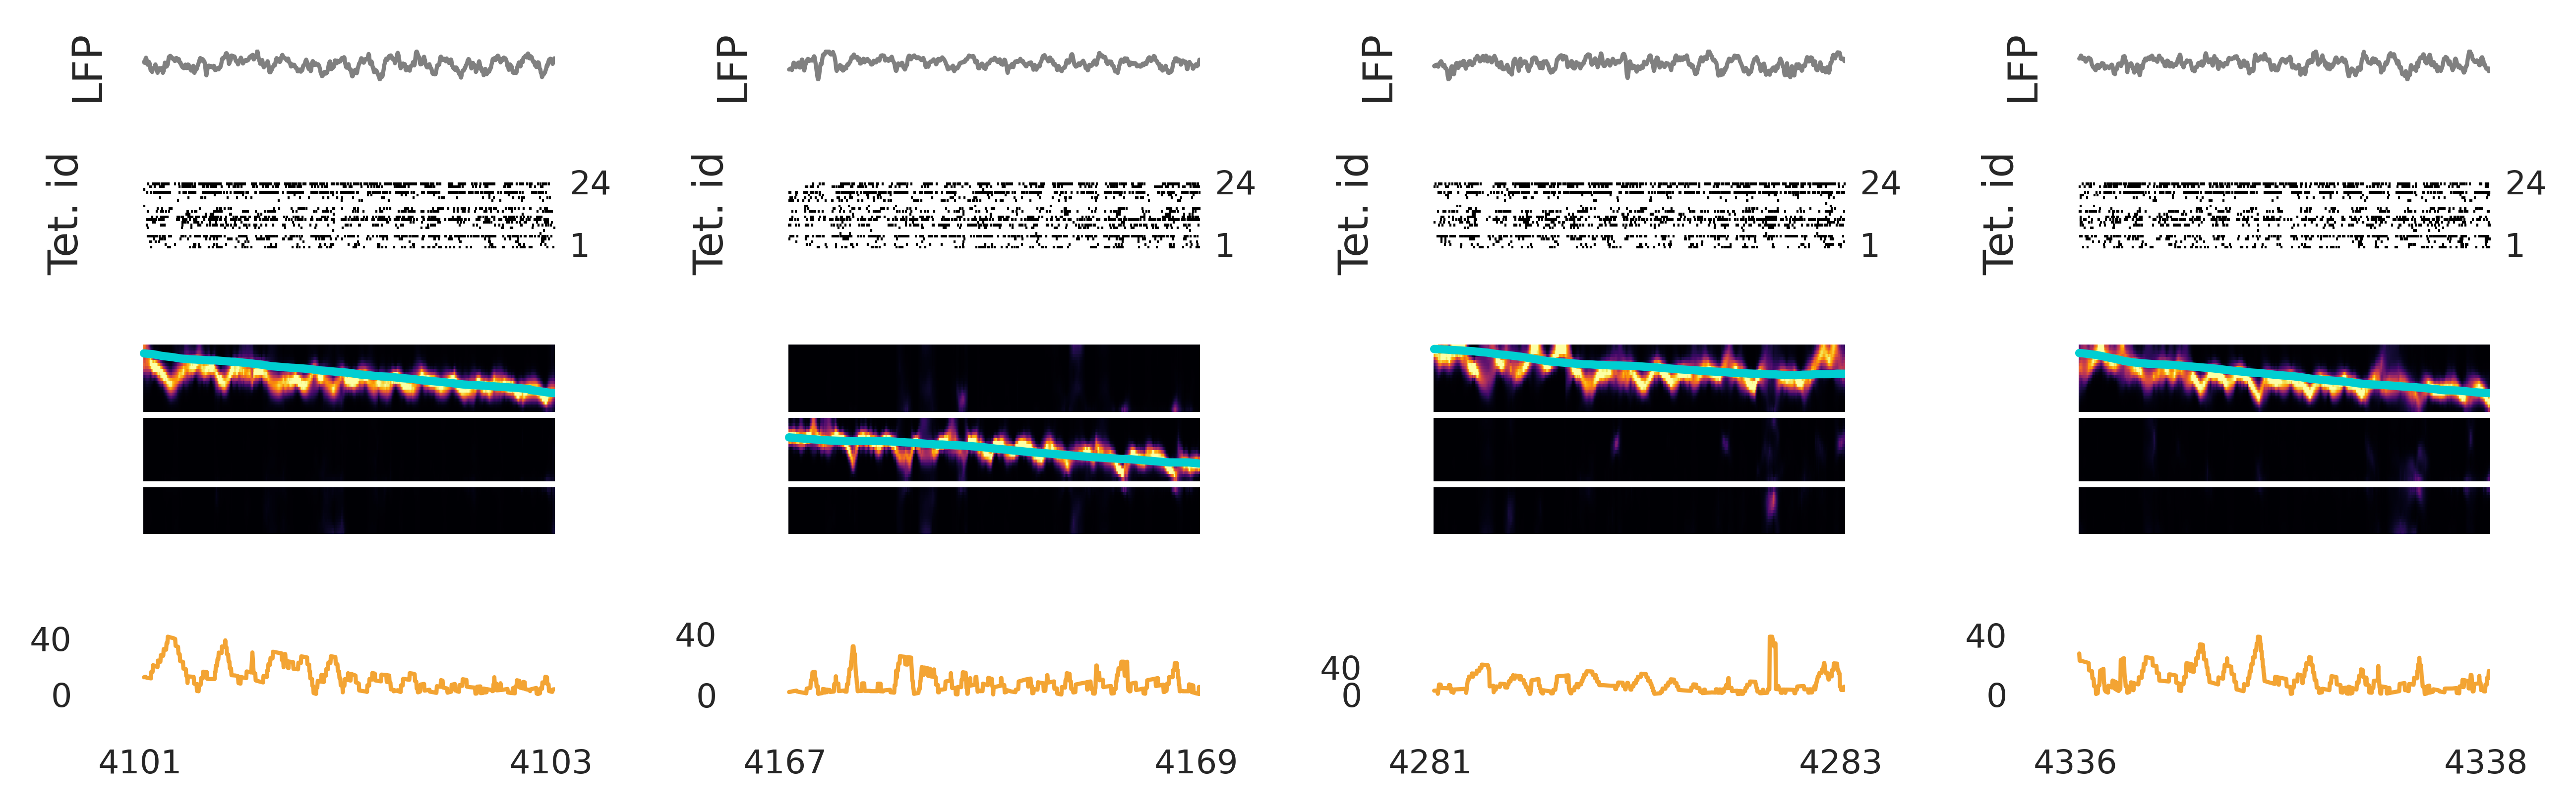

In [84]:
time_slice = slice(t.min(), t.max())  # 107-117
time_slice_sweep_1 = slice(t.min() + 455, t.min() + 457)
time_slice_sweep_2 = slice(t.min() + 521, t.min() + 523)
time_slice_sweep_3 = slice(t.min() + 635, t.min() + 637)
time_slice_sweep_4 = slice(t.min() + 690, t.min() + 692)

time_slice_sweep = [
    time_slice_sweep_1,
    time_slice_sweep_2,
    time_slice_sweep_3,
    time_slice_sweep_4,
]

plot_theta_examples(
    time_slice_sweep,
    t,
    multiunit_times,
    cv_classifier_clusterless_results,
    data,
    savename="FigSI_theta_sweep_more_examples2.png",
)